## 範例重點
* 學習如何在 keras 中加入 reduce learning rate
* 知道如何設定 reduce_lr 的監控目標
* 比較使用有無使用 reduce_lr 時的 performance

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tf.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss

參數說明：
monitor: 監控目標
min_lr: 最低下降至多少學習率
factor: 每次學習率要下降多少
patience: 經過多少 Epoch 後模型沒有改善時會使用該功能

"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [12]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss

參數說明：
monitor: 監控目標
min_lr: 最低下降至多少學習率
factor: 每次學習率要下降多少
patience: 經過多少 Epoch 後模型沒有改善時會使用該功能

"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=10, 
                              verbose=1)

In [13]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
49/49 [==============================] - 2s 30ms/step - loss: 1.7854 - accuracy: 0.3805 - val_loss: 3.6765 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 2/10
49/49 [==============================] - 1s 22ms/step - loss: 1.5101 - accuracy: 0.4682 - val_loss: 1.7955 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 3/10
49/49 [==============================] - 1s 21ms/step - loss: 1.4073 - accuracy: 0.5034 - val_loss: 1.7231 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 4/10
49/49 [==============================] - 1s 15ms/step - loss: 1.3286 - accuracy: 0.5314 - val_loss: 1.6532 - val_accuracy: 0.4109 - lr: 0.0010
Epoch 5/10
49/49 [==============================] - 1s 13ms/step - loss: 1.2543 - accuracy: 0.5575 - val_loss: 1.6519 - val_accuracy: 0.4048 - lr: 0.0010
Epoch 6/10
49/49 [==============================] - 1s 13ms/step - loss: 1.2033 - accuracy: 0.5779 - val_loss: 1.8772 - val_accuracy: 0.3671 - lr: 0.0010
Epoch 7/10
49/49 [==============================] - 1s 13ms/step - loss: 1.1

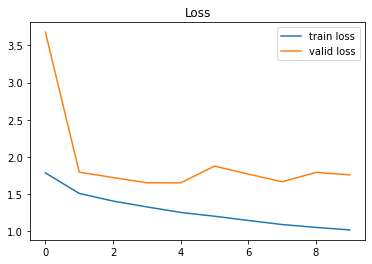

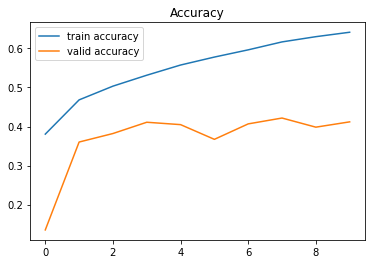

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [10]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
49/49 [==============================] - 4s 19ms/step - loss: 1.7504 - accuracy: 0.3934 - val_loss: 2.5459 - val_accuracy: 0.2131 - lr: 0.0010
Epoch 2/10
49/49 [==============================] - 1s 13ms/step - loss: 1.4868 - accuracy: 0.4774 - val_loss: 1.9429 - val_accuracy: 0.3288 - lr: 0.0010
Epoch 3/10
49/49 [==============================] - 1s 13ms/step - loss: 1.3874 - accuracy: 0.5106 - val_loss: 1.7466 - val_accuracy: 0.3850 - lr: 0.0010
Epoch 4/10
49/49 [==============================] - 1s 13ms/step - loss: 1.3100 - accuracy: 0.5377 - val_loss: 1.7741 - val_accuracy: 0.3717 - lr: 0.0010
Epoch 5/10
49/49 [==============================] - 1s 13ms/step - loss: 1.2500 - accuracy: 0.5596 - val_loss: 1.8973 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 6/10
49/49 [==============================] - 1s 13ms/step - loss: 1.1897 - accuracy: 0.5832 - val_loss: 1.6549 - val_accuracy: 0.4221 - lr: 0.0010
Epoch 7/10
49/49 [==============================] - 1s 13ms/step - loss: 1.1

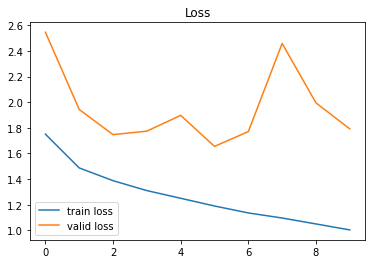

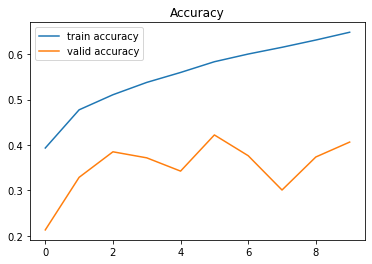

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果